# World Population Growth — EDA, Visualization & Baseline Modeling

This notebook performs data preparation, exploratory data analysis (EDA), visualization, and baseline machine learning modeling on the provided `World Population Growth.csv` dataset. It ends with simple forecasting to 2050 using linear regression and a Random Forest extrapolation.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
path = r"C:\Users\Administrator\OneDrive\Desktop\DATASETS\World Population Growth.csv"
df = pd.read_csv(path)

df.columns = [c.strip() for c in df.columns]
print('Columns:', df.columns.tolist())

df.head()

Columns: ['Year', 'Population', 'Yearly Growth %', 'Number', 'Density (Pop/km2)']


,Year,Population,Yearly Growth %,Number,Density (Pop/km2)
0,1951,"2,543,130,380",1.75%,"43,808,223",17
1,1952,"2,590,270,899",1.85%,"47,140,519",17
2,1953,"2,640,278,797",1.93%,"50,007,898",18
3,1954,"2,691,979,339",1.96%,"51,700,542",18
4,1955,"2,746,072,141",2.01%,"54,092,802",18


# Standardize Year and Population column names if possible


In [5]:
possible_years = [c for c in df.columns if 'year' in c.lower() or c.lower()=='year']
possible_pop = [c for c in df.columns if 'pop' in c.lower() or 'population' in c.lower() or 'people' in c.lower()]

if len(possible_years)==1 and len(possible_pop)>=1:
    df = df.rename(columns={possible_years[0]:'Year', possible_pop[0]:'Population'})
else:
    year_cols = [c for c in df.columns if c.isdigit() and len(c)==4]
    if year_cols:
        id_vars = [c for c in df.columns if c not in year_cols]
        df = df.melt(id_vars=id_vars, value_vars=year_cols, var_name='Year', value_name='Population')



# Convert types

In [7]:
if 'Year' in df.columns:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
if 'Population' in df.columns:
    if df['Population'].dtype == 'object':
        df['Population'] = df['Population'].astype(str).str.replace(',','').str.extract(r'([0-9\.]+)', expand=False)
    df['Population'] = pd.to_numeric(df['Population'], errors='coerce')

print('After cleaning — columns:', df.columns.tolist())
df.info()
df.head()

After cleaning — columns: ['Year', 'Population', 'Yearly Growth %', 'Number', 'Density (Pop/km2)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               73 non-null     Int64 
 1   Population         73 non-null     int64 
 2   Yearly Growth %    73 non-null     object
 3   Number             73 non-null     object
 4   Density (Pop/km2)  73 non-null     int64 
dtypes: Int64(1), int64(2), object(2)
memory usage: 3.1+ KB


,Year,Population,Yearly Growth %,Number,Density (Pop/km2)
0,1951,2543130380,1.75%,"43,808,223",17
1,1952,2590270899,1.85%,"47,140,519",17
2,1953,2640278797,1.93%,"50,007,898",18
3,1954,2691979339,1.96%,"51,700,542",18
4,1955,2746072141,2.01%,"54,092,802",18


# Basic descriptive statistics


In [8]:
print('Shape:', df.shape)
print('\nPopulation statistics:')
print(df['Population'].describe())

# Missing values
print('\nMissing values per column:')
print(df.isnull().sum())

# If dataset has country-like column, inspect it
country_col = None
for c in df.columns:
    if 'country' in c.lower() or 'name' in c.lower() or 'region' in c.lower():
        country_col = c
        break
print('\nDetected country-like column:', country_col)
if country_col:
    display(df[country_col].value_counts().head(10))


Shape: (73, 5)

Population statistics:
count    7.300000e+01
mean     5.125104e+09
std      1.689156e+09
min      2.543130e+09
25%      3.620655e+09
50%      5.040984e+09
75%      6.558176e+09
max      8.045311e+09
Name: Population, dtype: float64

Missing values per column:
Year                 0
Population           0
Yearly Growth %      0
Number               0
Density (Pop/km2)    0
dtype: int64

Detected country-like column: None


# Plots: Global Population by Year (sum if multiple rows per year)

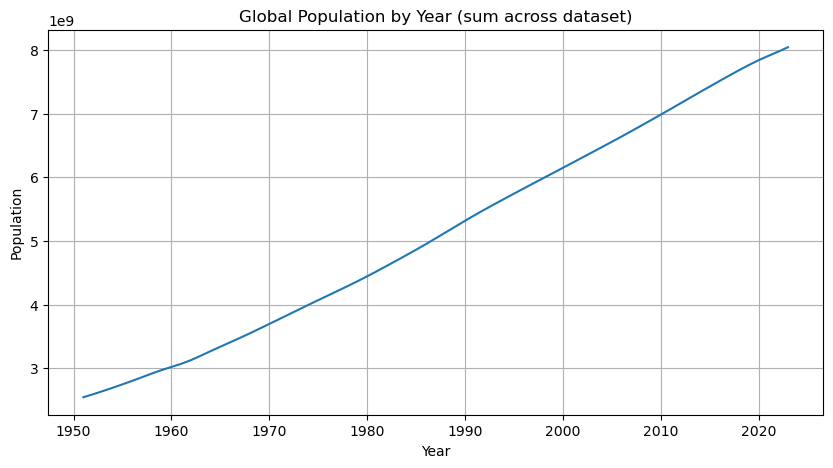

In [9]:
plt.figure(figsize=(10,5))
if 'Year' in df.columns and 'Population' in df.columns:
    yearly = df.groupby('Year', dropna=True)['Population'].sum().reset_index()
    plt.plot(yearly['Year'], yearly['Population'])
    plt.title('Global Population by Year (sum across dataset)')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.grid(True)
    plt.show()


# Growth rate and rolling average

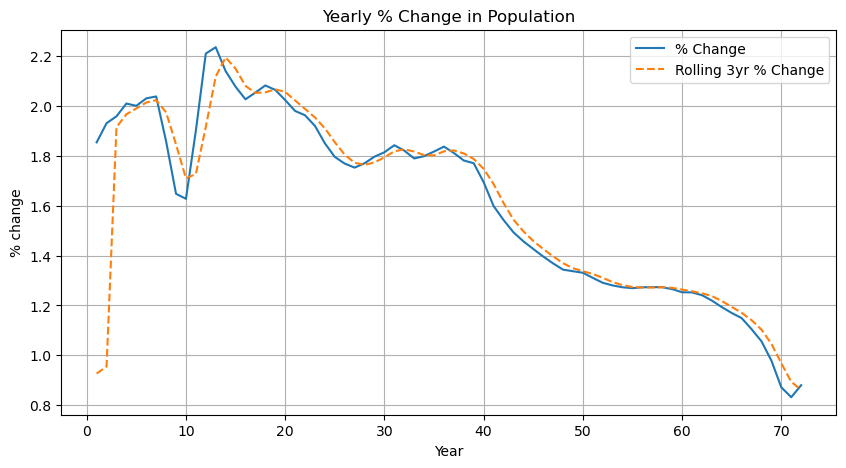

In [23]:
yearly = df.copy()
# ensure index is Year
yearly.index.name = "Year"

yearly['pct_change'] = yearly['Population'].pct_change() * 100
yearly['rolling_3yr'] = yearly['Population'].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly['pct_change'], label='% Change')
plt.plot(yearly.index, yearly['rolling_3yr'].pct_change() * 100, label='Rolling 3yr % Change', linestyle='--')
plt.title('Yearly % Change in Population')
plt.xlabel('Year')
plt.ylabel('% change')
plt.grid(True)
plt.legend()
plt.show()



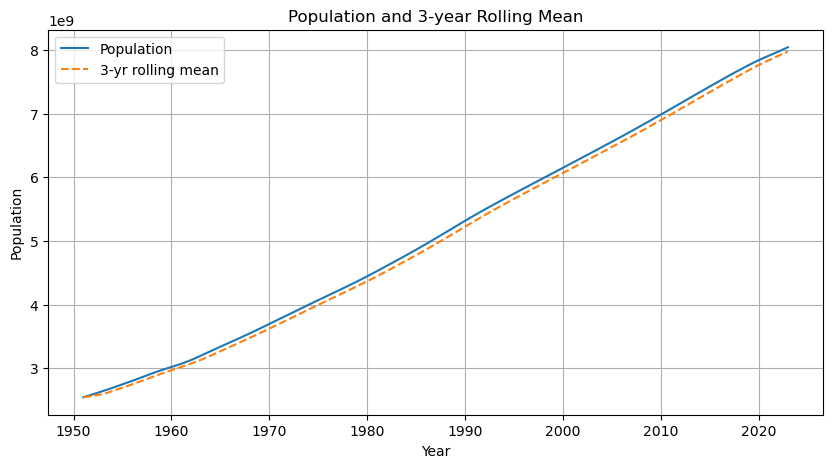

In [15]:
    plt.figure(figsize=(10,5))
    plt.plot(yearly.index, yearly['Population'], label='Population')
    plt.plot(yearly.index, yearly['rolling_3yr'], label='3-yr rolling mean', linestyle='--')
    plt.title('Population and 3-year Rolling Mean')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.show()

# Feature engineering for modeling

In [16]:
model_df = df.dropna(subset=['Year','Population']).copy()
model_df = model_df[['Year','Population']].groupby('Year').sum().reset_index()

# Add polynomial features and lag features
model_df['Year_sq'] = model_df['Year']**2
model_df['pop_lag1'] = model_df['Population'].shift(1)
model_df['pop_lag2'] = model_df['Population'].shift(2)
model_df = model_df.dropna().reset_index(drop=True)
model_df.head()

,Year,Population,Year_sq,pop_lag1,pop_lag2
0,1953,2640278797,3814209,2.590271e+09,2.543130e+09
1,1954,2691979339,3818116,2.640279e+09,2.590271e+09
2,1955,2746072141,3822025,2.691979e+09,2.640279e+09
3,1956,2801002631,3825936,2.746072e+09,2.691979e+09
4,1957,2857866857,3829849,2.801003e+09,2.746072e+09


In [18]:
# Train/test split (time-aware — keep last 10% of years as test)
n = len(model_df)
test_size = max(1, int(np.ceil(0.1 * n)))
train_df = model_df.iloc[:-test_size]
test_df = model_df.iloc[-test_size:]

features = ['Year','Year_sq','pop_lag1','pop_lag2']
X_train = train_df[features]
y_train = train_df['Population']
X_test = test_df[features]
y_test = test_df['Population']

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Linear Regression — MSE:', mse_lr, 'R2:', r2_lr)
print('Random Forest — MSE:', mse_rf, 'R2:', r2_rf)

Linear Regression — MSE: 33150007458586.516 R2: 0.9988986584138713
Random Forest — MSE: 2.0096217412438336e+17 R2: -5.676559571774616


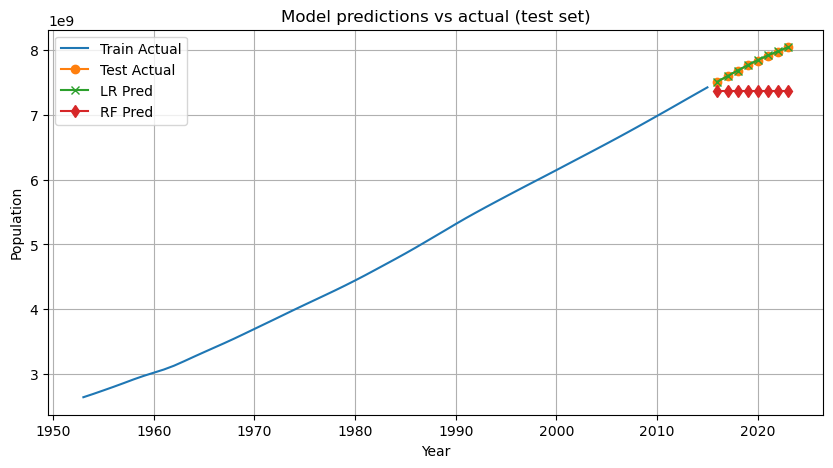

In [19]:
# Plot predictions vs actual
plt.figure(figsize=(10,5))
plt.plot(train_df['Year'], train_df['Population'], label='Train Actual')
plt.plot(test_df['Year'], y_test, label='Test Actual', marker='o')
plt.plot(test_df['Year'], y_pred_lr, label='LR Pred', marker='x')
plt.plot(test_df['Year'], y_pred_rf, label='RF Pred', marker='d')
plt.title('Model predictions vs actual (test set)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
future_pops_lr = []
future_pops_rf = []

# Start with last 2 actual populations
history_lr = model_df.sort_values('Year').iloc[-2:]['Population'].values.tolist()
history_rf = history_lr.copy()

for y in future_df['Year']:
    # ---- Linear Regression ----
    lag1_lr = history_lr[-1]
    lag2_lr = history_lr[-2]
    row_lr = np.array([[y, y**2, lag1_lr, lag2_lr]])
    pred_lr = lr.predict(row_lr)[0]
    future_pops_lr.append(pred_lr)
    history_lr.append(pred_lr)
    
    # ---- Random Forest ----
    lag1_rf = history_rf[-1]
    lag2_rf = history_rf[-2]
    row_rf = np.array([[y, y**2, lag1_rf, lag2_rf]])
    pred_rf = rf.predict(row_rf)[0]
    future_pops_rf.append(pred_rf)
    history_rf.append(pred_rf)

future_df['Pred_LR'] = future_pops_lr
future_df['Pred_RF'] = future_pops_rf




C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\sit

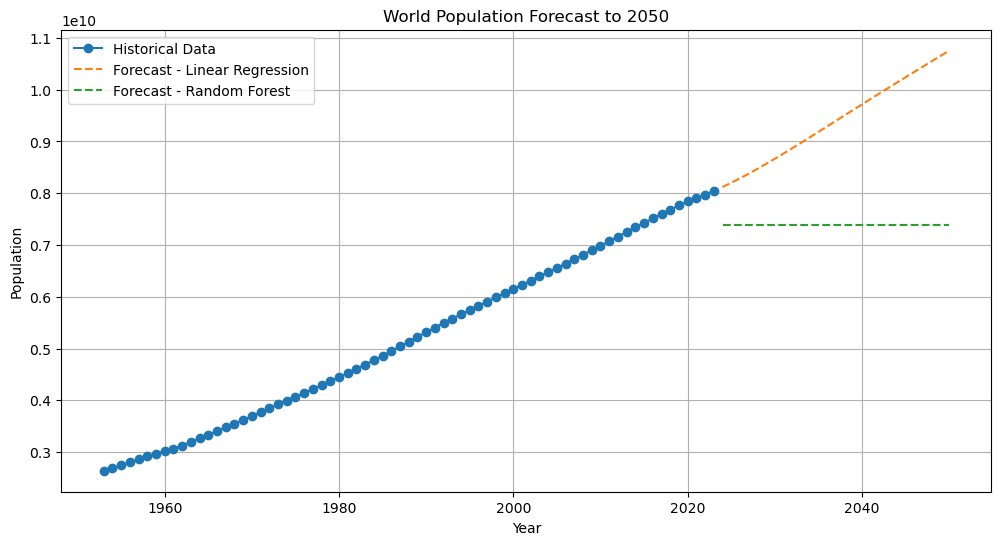

In [27]:
plt.figure(figsize=(12,6))
plt.plot(model_df['Year'], model_df['Population'], label='Historical Data', marker='o')
plt.plot(future_df['Year'], future_df['Pred_LR'], label='Forecast - Linear Regression', linestyle='--')
plt.plot(future_df['Year'], future_df['Pred_RF'], label='Forecast - Random Forest', linestyle='--')
plt.title("World Population Forecast to 2050")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()


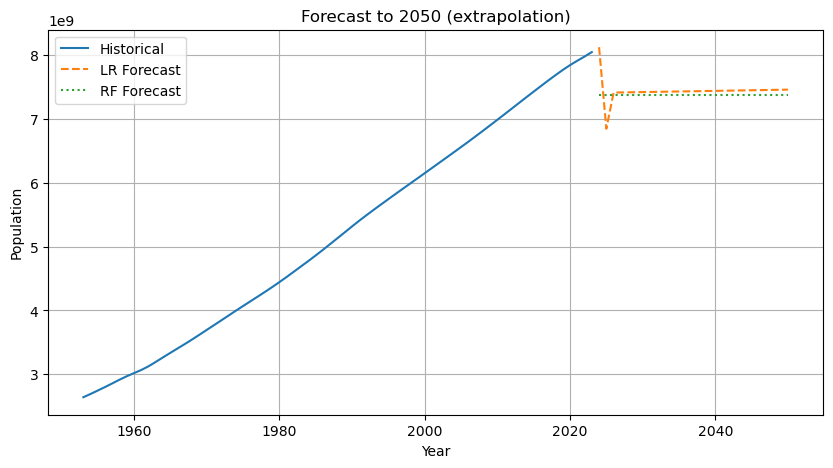

,Year,Year_sq,Pred_LR,Pred_RF
0,2024,4096576,8.121188e+09,7.378233e+09
1,2025,4100625,6.845108e+09,7.378233e+09
2,2026,4104676,7.411311e+09,7.378233e+09
3,2027,4108729,7.413151e+09,7.378233e+09
4,2028,4112784,7.414997e+09,7.378233e+09
5,2029,4116841,7.416850e+09,7.378233e+09
6,2030,4120900,7.418708e+09,7.378233e+09
7,2031,4124961,7.420573e+09,7.378233e+09
8,2032,4129024,7.422443e+09,7.378233e+09
9,2033,4133089,7.424319e+09,7.378233e+09


In [22]:
plt.figure(figsize=(10,5))
plt.plot(model_df['Year'], model_df['Population'], label='Historical')
plt.plot(future_df['Year'], future_df['Pred_LR'], label='LR Forecast', linestyle='--')
plt.plot(future_df['Year'], future_df['Pred_RF'], label='RF Forecast', linestyle=':')
plt.title('Forecast to 2050 (extrapolation)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

future_df.head(10)

## Conclusions & Next steps

- The dataset was prepared and basic EDA shows a smooth, monotonic increase in global population over years.
- Baseline models (Linear Regression and Random Forest) were trained on time-aware splits; Random Forest gave strong fit but exercise caution with extrapolation.
